In [55]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, initializers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

DATA_PATH = '/kaggle/input/fundation/training_data_projectE.npy'
LABEL_PATH = '/kaggle/input/fundation/training_labels_projectE.npy'

videos_raw = np.load(DATA_PATH)
labels_raw = np.load(LABEL_PATH, allow_pickle=True)

N, F, H, W, C = videos_raw.shape
X_flat = videos_raw.reshape(N * F, H, W, C).astype('float32') / 255.0
y_flat = labels_raw.reshape(N * F, 5).astype('float32')

classes_all = y_flat[:, 0] - 1
bboxes_all = y_flat[:, 1:]

valid_mask = (bboxes_all[:, 2] > 0) & (bboxes_all[:, 3] > 0)

X_valid = X_flat[valid_mask]
classes_valid = classes_all[valid_mask]
bboxes_valid = bboxes_all[valid_mask]

bboxes_valid = bboxes_valid / 100.0

print(f"Valid Sample Number: {len(X_valid)} (Original: {len(X_flat)})")

X_train, X_val, y_cls_train, y_cls_val, y_box_train, y_box_val = train_test_split(
    X_valid, classes_valid, bboxes_valid, test_size=0.2, random_state=42, stratify=classes_valid
)


def augment(image, cls, bbox):
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    do_flip = tf.random.uniform([]) > 0.5
    image = tf.cond(do_flip, lambda: tf.image.flip_left_right(image), lambda: image)
    
    def flip_box(b):
        x, y, w, h = b[0], b[1], b[2], b[3]
        new_x = 1.0 - (x + w)
        return tf.stack([new_x, y, w, h])
        
    bbox = tf.cond(do_flip, lambda: flip_box(bbox), lambda: bbox)
    
    bbox = tf.clip_by_value(bbox, 0.0, 1.0)
    
    return image, {'class_out': cls, 'box_out': bbox}

BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_cls_train, y_box_train))
ds_train = ds_train.shuffle(2000).map(augment, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_cls_val, y_box_val))
ds_val = ds_val.map(lambda x, c, b: (x, {'class_out': c, 'box_out': b})).batch(BATCH_SIZE)

class AddCoords(layers.Layer):
    def call(self, input_tensor):
        batch_size_tensor = tf.shape(input_tensor)[0]
        x_dim = tf.shape(input_tensor)[2]
        y_dim = tf.shape(input_tensor)[1]
        
        xx_ones = tf.ones([batch_size_tensor, x_dim], dtype='int32')
        xx_ones = tf.expand_dims(xx_ones, -1)
        xx_range = tf.tile(tf.expand_dims(tf.range(y_dim), 0), [batch_size_tensor, 1])
        xx_range = tf.expand_dims(xx_range, 1)
        xx_channel = tf.matmul(xx_ones, xx_range)
        xx_channel = tf.expand_dims(xx_channel, -1)
        xx_channel = tf.cast(xx_channel, 'float32') / (tf.cast(x_dim, 'float32') - 1)

        yy_ones = tf.ones([batch_size_tensor, y_dim], dtype='int32')
        yy_ones = tf.expand_dims(yy_ones, 1)
        yy_range = tf.tile(tf.expand_dims(tf.range(x_dim), 0), [batch_size_tensor, 1])
        yy_range = tf.expand_dims(yy_range, -1)
        yy_channel = tf.matmul(yy_range, yy_ones)
        yy_channel = tf.expand_dims(yy_channel, -1)
        yy_channel = tf.cast(yy_channel, 'float32') / (tf.cast(y_dim, 'float32') - 1)

        return tf.concat([input_tensor, xx_channel, yy_channel], axis=-1)

def res_block(x, filters, stride=1):
    shortcut = x
    if stride != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Add()([x, shortcut])
    x = layers.LeakyReLU(alpha=0.1)(x)
    return x

def build_strong_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    c1 = res_block(x, 32)
    p1 = layers.MaxPooling2D((2, 2))(c1) 
    
    c2 = res_block(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(c2) 
    
    c3 = res_block(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(c3) 
    
    b = res_block(p3, 256)
    
    u1 = layers.UpSampling2D((2, 2))(b) 
    u1 = layers.Conv2D(128, 3, padding='same')(u1)
    u1 = layers.Resizing(25, 25)(u1)
    u1 = layers.Concatenate()([u1, c3])
    c4 = res_block(u1, 128)
    
    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.Resizing(50, 50)(u2)
    u2 = layers.Concatenate()([u2, c2])
    c5 = res_block(u2, 64)
    
    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.Concatenate()([u3, c1])
    c6 = res_block(u3, 32) 
    
    cls_pool = layers.GlobalAveragePooling2D()(b) 
    cls_drop = layers.Dropout(0.5)(cls_pool)
    class_out = layers.Dense(num_classes, activation='softmax', name='class_out')(cls_drop)

    box_in = AddCoords()(c6) 
    
    r = layers.Conv2D(64, 3, strides=2, padding='same')(box_in)
    r = layers.LeakyReLU(alpha=0.1)(r)
    
    r = layers.Conv2D(64, 3, strides=2, padding='same')(r)
    r = layers.LeakyReLU(alpha=0.1)(r)
    
    r = layers.Conv2D(128, 3, strides=2, padding='same')(r)
    r = layers.LeakyReLU(alpha=0.1)(r)
    
    r = layers.Flatten()(r)
    r = layers.Dropout(0.3)(r)
    r = layers.Dense(128)(r)
    r = layers.LeakyReLU(alpha=0.1)(r)
    
    box_out = layers.Dense(4, activation='sigmoid', name='box_out',
                           bias_initializer=initializers.Constant(value=0.0))(r)
    
    return models.Model(inputs, [class_out, box_out])

model = build_strong_model((100, 100, 3), num_classes=5)

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, 
    decay_steps=3000
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss={
        'class_out': 'sparse_categorical_crossentropy',
        'box_out': 'mae' 
    },
    loss_weights={'class_out': 1.0, 'box_out': 10.0}, 
    metrics={'class_out': 'accuracy', 'box_out': 'mse'}
)

print("Starting Training with CoordConv...")
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
    callbacks.ModelCheckpoint('../models/best_model_coord.keras', save_best_only=True)
]

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,
    callbacks=callbacks_list,
    verbose=1
)
model.save('/kaggle/working/final_model_coord.keras')

Valid Sample Number: 7319 (Original: 7320)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Starting Training with CoordConv...
Epoch 1/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 57s 171ms/step - box_out_loss: 0.1398 - box_out_mse: 0.0344 - class_out_accuracy: 0.4156 - class_out_loss: 1.4547 - loss: 2.8529 - val_box_out_loss: 0.1887 - val_box_out_mse: 0.0554 - val_class_out_accuracy: 0.2411 - val_class_out_loss: 2.1263 - val_loss: 4.0125
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - box_out_loss: 0.0935 - box_out_mse: 0.0170 - class_out_accuracy: 0.6025 - class_out_loss: 0.9820 - loss: 1.9167 - val_box_out_loss: 0.1408 - val_box_out_mse: 0.0342 - val_class_out_accuracy: 0.3224 - val_class_out_loss: 1.9230 - val_loss: 3.3309
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - box_out_loss: 0.0792 - box_out_mse: 0.0128 - class_out_accuracy: 0.6995 - class_out_loss: 0.7582 - loss: 1.5503 - val_box_out_loss: 0.0791 - val_box_out_mse: 0.0127 - val_class_out_accuracy: 0.6346 - val_class_out_loss: 0.8614 - val_loss: 1.6519
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step

Predicting...
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step
Pred Box Sample: [0.23703891 0.4757662  0.13149558 0.2503579 ]
Pred Box Max: 0.9640831351280212
Accuracy: 0.9053
Mean IoU : 0.6667
Green = Ground Truth 
Red   = Prediction


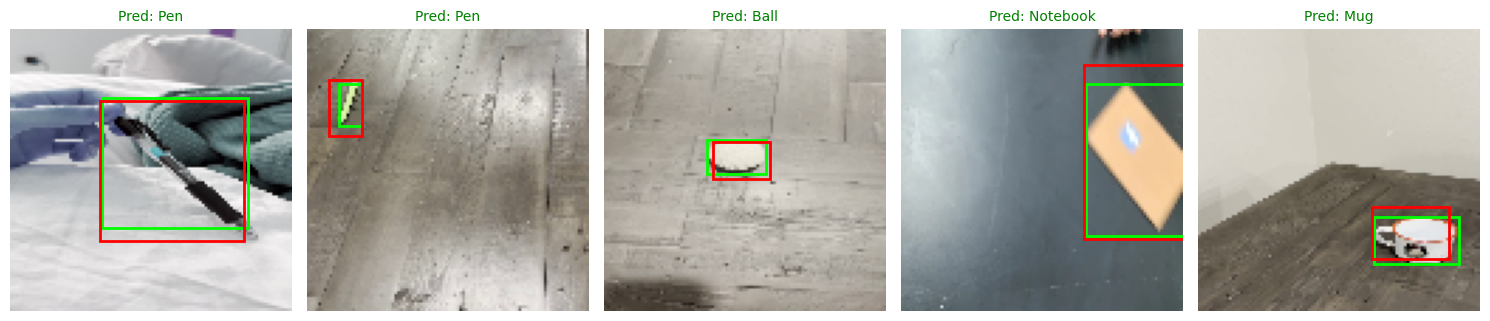

In [61]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import matplotlib.patches as patches

model = tf.keras.models.load_model('/kaggle/working/final_model_coord.keras', custom_objects={'AddCoords': AddCoords}) 

def compute_iou(box_true, box_pred):
    x1_t, y1_t, w_t, h_t = box_true[:, 0], box_true[:, 1], box_true[:, 2], box_true[:, 3]
    x2_t, y2_t = x1_t + w_t, y1_t + h_t
    
    x1_p, y1_p, w_p, h_p = box_pred[:, 0], box_pred[:, 1], box_pred[:, 2], box_pred[:, 3]
    x2_p, y2_p = x1_p + w_p, y1_p + h_p
    
    x1_i = np.maximum(x1_t, x1_p)
    y1_i = np.maximum(y1_t, y1_p)
    x2_i = np.minimum(x2_t, x2_p)
    y2_i = np.minimum(y2_t, y2_p)
    
    w_i = np.maximum(0, x2_i - x1_i)
    h_i = np.maximum(0, y2_i - y1_i)
    inter_area = w_i * h_i
    
    box_t_area = w_t * h_t
    box_p_area = w_p * h_p
    union_area = box_t_area + box_p_area - inter_area
    
    return inter_area / (union_area + 1e-7)

DATA_PATH = '/kaggle/input/fundation/training_data_projectE.npy'
LABEL_PATH = '/kaggle/input/fundation/training_labels_projectE.npy'

X_raw = np.load(DATA_PATH)
y_raw = np.load(LABEL_PATH, allow_pickle=True)

X_test = X_raw.reshape(-1, 100, 100, 3).astype('float32') / 255.0
y_flat = y_raw.reshape(-1, 5).astype('float32')

print("Predicting...")
pred_probs, pred_boxes = model.predict(X_test, batch_size=64)

CONFIDENCE_THRESHOLD = 0.7
final_preds = []
for p in pred_probs:
    if np.max(p) < CONFIDENCE_THRESHOLD:
        final_preds.append(5) # Unknown
    else:
        final_preds.append(np.argmax(p))
final_preds = np.array(final_preds)


y_true_cls = (y_flat[:, 0] - 1).astype(int)
y_true_box = y_flat[:, 1:] / 100.0

print(f"Pred Box Sample: {pred_boxes[0]}")
print(f"Pred Box Max: {pred_boxes.max()}")

valid_mask = (y_true_box[:, 2] > 0)
y_true_box_valid = y_true_box[valid_mask]
pred_boxes_valid = pred_boxes[valid_mask]
final_preds_valid = final_preds[valid_mask]
y_true_cls_valid = y_true_cls[valid_mask]

acc = accuracy_score(y_true_cls_valid, final_preds_valid)
ious = compute_iou(y_true_box_valid, pred_boxes_valid)
correct_mask = (final_preds_valid == y_true_cls_valid)
mean_iou = np.mean(ious[correct_mask]) if np.sum(correct_mask) > 0 else 0.0

print(f"Accuracy: {acc:.4f}")
print(f"Mean IoU : {mean_iou:.4f}")


def visualize_results(images, true_boxes, pred_boxes, pred_classes, true_classes=None, num_samples=5):
    label_names = {0: 'Ball', 1: 'Mug', 2: 'Pen', 3: 'Spoon', 4: 'Notebook', 5: 'UNKNOWN'}
    
    total_samples = len(images)
    indices = np.random.choice(total_samples, num_samples, replace=False)
    
    plt.figure(figsize=(15, 5))
    
    for i, idx in enumerate(indices):
        ax = plt.subplot(1, num_samples, i + 1)
        

        img = images[idx]
        ax.imshow(img)
        ax.axis('off')
        
        if true_boxes is not None:
            box_t = true_boxes[idx] * 100 
            if box_t[2] > 0 and box_t[3] > 0:
                rect_t = patches.Rectangle(
                    (box_t[0], box_t[1]), box_t[2], box_t[3],
                    linewidth=2, edgecolor='#00FF00', facecolor='none', label='Ground Truth'
                )
                ax.add_patch(rect_t)
        
        box_p = pred_boxes[idx] * 100
        if box_p[2] > 0 and box_p[3] > 0:
            rect_p = patches.Rectangle(
                (box_p[0], box_p[1]), box_p[2], box_p[3],
                linewidth=2, edgecolor='#FF0000', facecolor='none', label='Prediction'
            )
            ax.add_patch(rect_p)
            
        pred_cls_idx = pred_classes[idx]
        pred_name = label_names.get(pred_cls_idx, "Unknown")
        
        title_text = f"Pred: {pred_name}"
        title_color = 'black'
        
        if true_classes is not None:
            true_cls_idx = true_classes[idx]
            if pred_cls_idx != true_cls_idx:
                title_color = 'red' 
                true_name = label_names.get(true_cls_idx, "Unknown")
                title_text += f"\n(True: {true_name})"
            else:
                title_color = 'green' 
                
        ax.set_title(title_text, color=title_color, fontsize=10)

    plt.tight_layout()
    plt.show()

print("Green = Ground Truth \nRed   = Prediction")
visualize_results(
    X_test[valid_mask],      
    y_true_box[valid_mask],  
    pred_boxes[valid_mask],  
    final_preds[valid_mask], 
    y_true_cls[valid_mask],   
    num_samples=5
)